# 0.0. Entender Problema

-- Objetivo do Problema:
    -- 1.0. Previsao do primeiro destino que um novo usuário irá escolher.
    
    -- Porque?
        -- Qual tipo de modelo de negócio do Airbnb?
            -- Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
            -- Oferta ( pessoas oferecendo acomodacao )
                -- Tamanho do portfólio.
                -- Diversidade/Densidade de Portfólio.
                -- Preco Medio
                
            -- Demanda ( pessoas procurando acomodacao )
                -- Numero de Usuários
                -- LTV ( Lifetime Value )
                -- CAC ( Client Acquisition Cost )
                
                
               Gross Revenue = ( Fee*Numero cliente ) - CAC 
    
-- Proposta da Solucao

    --- Modelo de Predivao do primeiro destino de um novo usario.
    --- 1.0. Predicoes e salva em tabela do banco de dados. 
    --- 2.0. API 
            --- Input: usuario e suas caracteristicas
            --- Output: usuario e suas caracteristicas com a **predicao do destino**
            
    --- 16 ciclos

# <font color='red'> Ciclo01: End to End </font>

# 0.0. Imports

In [1]:
import random
import numpy   as np
import pandas  as pd
import seaborn as sns

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt
from scipy      import stats           as ss

from imblearn   import under_sampling  as us
from imblearn   import over_sampling   as oversamp
from imblearn   import combine         as c

from keras import models as ml
from keras import layers as l

/Users/meigarom.lopes/.pyenv/versions/3.8.0/envs/airbnbpredictfirstbooking/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2. Loading Data

In [3]:
df_raw = pd.read_csv( 'dataset/training_users.csv', low_memory=True )
df_raw.shape

(213451, 16)

In [4]:
df_sessions = pd.read_csv( 'dataset/sessions.csv', low_memory=True )
df_sessions.shape

(10567737, 6)

# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1. Data Dimension

In [6]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 213451
Number of columns: 16


In [7]:
print( 'Number of rows: {}'.format( df_sessions.shape[0] ) )
print( 'Number of columns: {}'.format( df_sessions.shape[1] ) )

Number of rows: 10567737
Number of columns: 6


## 1.2. Data Type

In [8]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [9]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. NA Check

In [10]:
df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [11]:
df_sessions.isna().sum() / len( df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [12]:
# remove missing value completly
#df1 = df1.dropna()

# ========== User =================
# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )

# age
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = df1['age'].mean().astype( int )
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions =================
# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

In [13]:
df1.isna().sum() / len( df1 )

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [14]:
df_sessions.isna().sum() / len( df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.4. Change Data Type

In [15]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [16]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

## 1.5. Check Balanced Data

In [17]:
#df1['country_destination'].value_counts( normalize=True )
df1['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 1.6. Descriptive Analysis

In [18]:
# Users
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

# Sessions
num_attributes_sessions = df_sessions.select_dtypes( include=['int64', 'float64'] )
cat_attributes_sessions = df_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes_sessions = df_sessions.select_dtypes( include=['datetime64[ns]'] )

### 1.6.1. Numerical - Users

In [19]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.2. Numerical - Sessions

In [20]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( num_attributes_sessions.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_sessions.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_sessions.apply( min ) ).T
d3 = pd.DataFrame( num_attributes_sessions.apply( max ) ).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.3. Categorial - Users

In [21]:
cat_attributes.drop( 'id', axis=1 ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.4. Categorial - Sesssions

In [22]:
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


### 1.6.5. Correlation Matrix - Sessions

In [23]:
cat_attributes_list = cat_attributes_sessions.drop( 'user_id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot:>

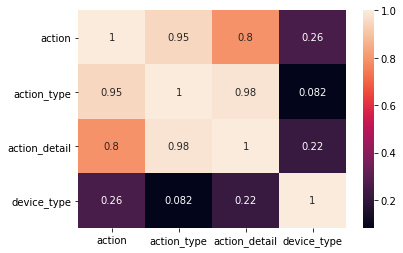

In [24]:
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

# 2.0. Feature Engineering

In [25]:
df2 = df1.copy()
df2.shape

(122636, 16)

In [26]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1. Create New Features

In [26]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_frist_active_until_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# days from first active upt to account created
df2['days_from_first_active_until_account_created'] = ( df2['date_account_created'] - df2['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df2['days_from_account_created_until_first_booking'] = ( df2['date_first_booking'] - df2['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================
# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_fist_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

# month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

<ipython-input-26-c95a4a9a186e>:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
<ipython-input-26-c95a4a9a186e>:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
<ipython-input-26-c95a4a9a186e>:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [27]:
df2.shape

(122636, 35)

# 3.0. Data Filtering

In [28]:
df3 = df2.copy()
df3.shape

(122636, 35)

## 3.1. Filtering Rows

In [29]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
#df3 = df3[df3['secs_elapsed'] > 0]

## 3.2. Columns Selection

In [30]:
cols = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 'first_active'] # original datetime
df3 = df3.drop( cols, axis=1 )

# 4.0. Balanced Dataset

In [31]:
df4 = df3.copy()
df4.shape

(122636, 31)

In [32]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes( include=['int64', 'float64'] ).columns.tolist()

# Categorical
col_cat = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).drop( ['id', 'country_destination'], axis=1 ).columns.tolist()

# encoding
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[ col_cat] ).toarray(), index=df4.index )

# join numerical and categorical
df42 = pd.concat( [df4[col_num], df4_dummy], axis=1 )
df42.shape

(122636, 138)

## 4.1. Random Undersampling

In [109]:
# ratio_balanced
ratio_balanced = {'NDF': 10000 }
# define sampler
undersampling = us.RandomUnderSampler( sampling_strategy=ratio_balanced, random_state=32 )

# apply sampler
X_under, y_under = undersampling.fit_resample( df42, df4['country_destination'] )

In [110]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [111]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 4.2. Random Oversampling

In [35]:
# ratio_balanced
#ratio_balanced = {'NDF': 10000 }

# define sampler
oversampling = oversamp.RandomOverSampler( sampling_strategy='all', random_state=32 )

# apply sampler
X_over, y_over = oversampling.fit_resample( df42, df4['country_destination'] )

In [36]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [37]:
y_over.value_counts()

FR       54852
AU       54852
other    54852
ES       54852
DE       54852
CA       54852
IT       54852
PT       54852
US       54852
NL       54852
GB       54852
NDF      54852
Name: country_destination, dtype: int64

## 4.3. SMOTE + TOMEKLINK

In [62]:
ratio_balanced =  {'NDF': 54852,
                   'US':  48057,
                   'other': 6*7511,
                   'FR': 12*3669,
                   'IT': 20*2014,
                   'GB': 30*1758,
                   'ES': 30*1685,
                   'CA': 40*1064,
                   'DE': 45*841,
                   'NL': 80*595,
                   'AU': 85*433,
                   'PT': 300*157}

In [63]:
# define sampler
smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# apply sampler
X_smt, y_smt = smt.fit_resample( df42, df4['country_destination'] )

In [64]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [65]:
y_over.value_counts()

FR       54852
AU       54852
other    54852
ES       54852
DE       54852
CA       54852
IT       54852
PT       54852
US       54852
NL       54852
GB       54852
NDF      54852
Name: country_destination, dtype: int64

In [67]:
# numerical data
df43 = X_smt[ col_num ]

# categorical data
df44 = X_smt.drop( col_num, axis=1 )
df45 = pd.DataFrame( ohe.inverse_transform( df44 ), columns=col_cat, index=df44.index )

# join numerical categorical
df46 = pd.concat( [df43, df45], axis=1 )
df46['country_destination'] = y_smt

# 5.0. Data Preparation

In [68]:
df5 = df4.copy()

In [69]:
# dummy variable
df5_dummy = pd.get_dummies( df5.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df5 = pd.concat( [df5[['id', 'country_destination']], df5_dummy], axis=1 )

In [70]:
df5.shape

(122636, 140)

# 6.0. Feature Selection

In [73]:
#cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # original dates
df6 = df5.copy()#drop( cols_drop, axis=1 )

In [74]:
X = df6.drop( 'country_destination', axis=1 )
y = df6['country_destination'].copy()

In [75]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

# 7.0. Machine Learning Model

In [76]:
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

## 7.1. Baseline Model

In [77]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

yhat_random = random.choices( population=country_destination_list,  
                              weights=country_destination_weights,
                              k=k_num )

### 7.1.1. Baseline Model Performance

Accuracy: 0.35918134377038485
Balanced Accuracy:0.08236018230085887
Kappa Score: 0.0024174456224165253
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.00      0.00      0.00       164
          ES       0.02      0.03      0.02       319
          FR       0.03      0.03      0.03       736
          GB       0.01      0.01      0.01       361
          IT       0.02      0.02      0.02       420
         NDF       0.45      0.45      0.45     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.39      0.39      0.39      9606
       other       0.06      0.06      0.06      1521

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

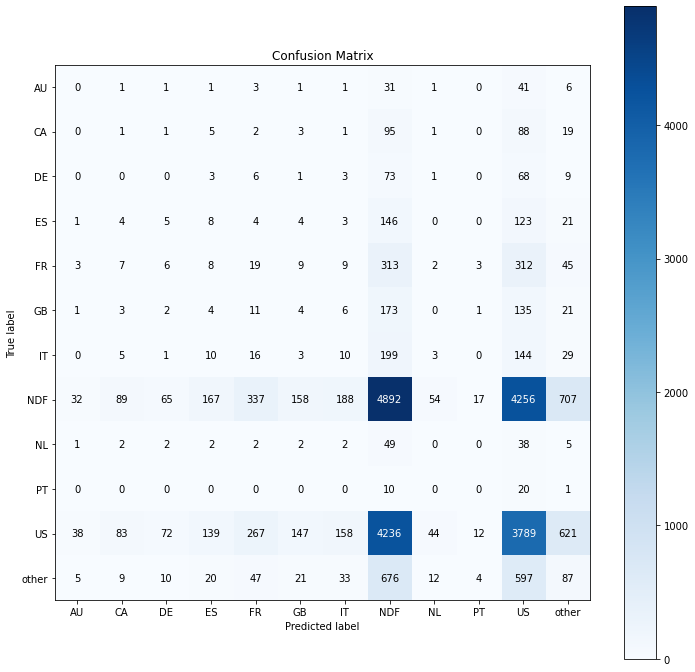

In [78]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score( y_test, yhat_random )
print( 'Balanced Accuracy:{}'.format( balanced_acc_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification report
print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12))

## 7.2. Neural Network - MLP

In [79]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [83]:
print( 'Number of Rows: {}'.format( x_train.shape[0] ) )
print( 'Number of Features: {}'.format( x_train.shape[1] ) )
print( 'Number of Classes: {}'.format( y_train.nunique() ) )

Number of Rows: 98108
Number of Features: 138
Number of Classes: 12


In [82]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
3066/3066 [==============================] - 3s 897us/step - loss: 7.2466 - accuracy: 0.7323
Epoch 2/100
3066/3066 [==============================] - 3s 842us/step - loss: 3.2238 - accuracy: 0.7476
Epoch 3/100
3066/3066 [==============================] - 3s 838us/step - loss: 1.6274 - accuracy: 0.7683
Epoch 4/100
3066/3066 [==============================] - 3s 874us/step - loss: 1.0565 - accuracy: 0.7933
Epoch 5/100
3066/3066 [==============================] - 3s 961us/step - loss: 0.8535 - accuracy: 0.81000s - loss: 0.8583 - accuracy
Epoch 6/100
3066/3066 [==============================] - 2s 704us/step - loss: 0.7022 - accuracy: 0.8316
Epoch 7/100
3066/3066 [==============================] - 2s 661us/step - loss: 0.6632 - accuracy: 0.8378
Epoch 8/100
3066/3066 [==============================] - 2s 655us/step - loss: 0.6465 - accuracy: 0.8383
Epoch 9/100
3066/3066 [==============================] - 2s 641us/step - loss: 0.6425 - accuracy: 0.8383
Epoch 10/100
3066/3066 [===

3066/3066 [==============================] - 2s 815us/step - loss: 0.6337 - accuracy: 0.8390
Epoch 78/100
3066/3066 [==============================] - 3s 825us/step - loss: 0.6336 - accuracy: 0.8391
Epoch 79/100
3066/3066 [==============================] - 2s 814us/step - loss: 0.6336 - accuracy: 0.8390
Epoch 80/100
3066/3066 [==============================] - 3s 833us/step - loss: 0.6343 - accuracy: 0.8390
Epoch 81/100
3066/3066 [==============================] - 2s 810us/step - loss: 0.6329 - accuracy: 0.8392
Epoch 82/100
3066/3066 [==============================] - 3s 830us/step - loss: 0.6351 - accuracy: 0.8390
Epoch 83/100
3066/3066 [==============================] - 3s 819us/step - loss: 0.6331 - accuracy: 0.8391
Epoch 84/100
3066/3066 [==============================] - 3s 842us/step - loss: 0.6337 - accuracy: 0.8391
Epoch 85/100
3066/3066 [==============================] - 3s 897us/step - loss: 0.6340 - accuracy: 0.8390
Epoch 86/100
3066/3066 [==============================] - 3

### 7.2.1. NN Performance

In [84]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

Accuracy: 0.8384703196347032
Balanced Accuracy:0.16664931639947256
Kappa Score: 0.7232441822459961


/Users/meigarom.lopes/.pyenv/versions/3.8.0/envs/airbnbpredictfirstbooking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.00      0.00      0.00       164
          ES       0.00      0.00      0.00       319
          FR       0.00      0.00      0.00       736
          GB       0.00      0.00      0.00       361
          IT       0.00      0.00      0.00       420
         NDF       1.00      1.00      1.00     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.71      1.00      0.83      9606
       other       0.00      0.00      0.00      1521

    accuracy                           0.84     24528
   macro avg       0.14      0.17      0.15     24528
weighted avg       0.72      0.84      0.77     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

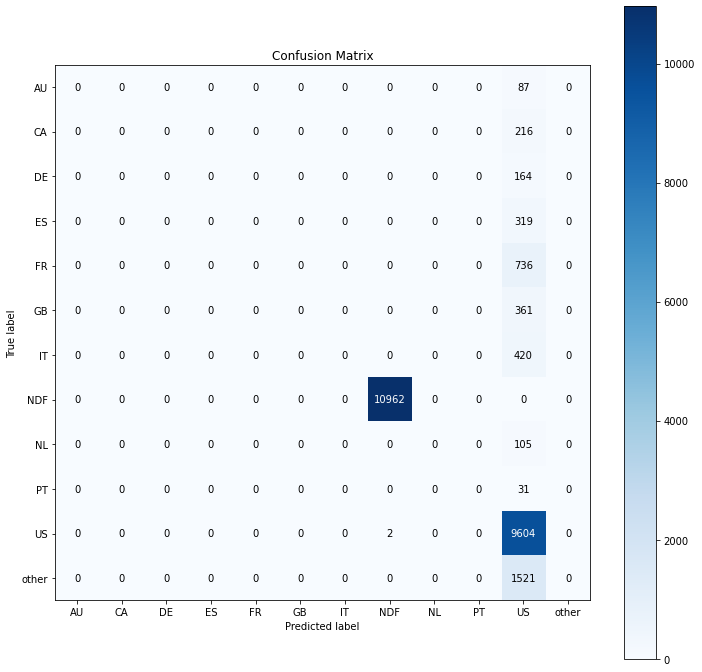

In [85]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
print( 'Balanced Accuracy:{}'.format( balanced_acc_nn ) )

# Kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score: {}'.format( kappa_nn ) )

# Classification report
print( m.classification_report( y_test_nn, yhat_nn ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

### 7.2.2. NN Performance - Cross-Validation

In [53]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 12, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [61]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 4 ), np.round( np.std( balanced_acc_list ), 4 ) ) )
print( 'Avg Kappa: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 4 ), np.round( np.std( kappa_acc_list ), 4 ) ) )

Avg Balanced Accuracy: 0.1666 +/- 0.0001
Avg Kappa: 0.724 +/- 0.0006
